# Pipelines

 * Machine learning applications require not only the application of a single algorithm, but the chaining together of many different processing steps and machine learning models.
 * We go all the way from preprocessing to model predictions.
 * **NB!** In a pipeline each step, but the last, must be a transformer and the last one must be an estimator, such as a classifier, regressor or transformer.

In [93]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, ElasticNet, Ridge
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn import datasets

## Pipeline() object

Imputing missing data & logistic regression:

In [3]:
diab = pd.read_csv('supervised/classification/data/diabetes.csv', header=0)
diab.head(1)

,pregnancies,glucose,diastolic,triceps,insulin,bmi,dpf,age,diabetes
0,6,148,72,35,0,33.6,0.627,50,1


In [5]:
diab.replace({'triceps':0, 'insulin':0, 'bmi':0}, np.nan, inplace=True)
diab.head(1)

,pregnancies,glucose,diastolic,triceps,insulin,bmi,dpf,age,diabetes
0,6,148,72,35.0,NaN,33.6,0.627,50,1


In [9]:
X = diab.drop('diabetes', axis=1).values
y = diab.diabetes.values

# init imputer object
imp = SimpleImputer(missing_values=np.nan, strategy='mean')

# init estimator object
logistic_reg = LogisticRegression(solver='liblinear')

# build the pipeline object. List of tuples. [('name', object), (), ..., ()]
steps = [('imputer', imp), ('logistic_regression', logistic_reg)]

# pipeline object
pipe = Pipeline(steps=steps)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

print("Logistic Regression R^2 = {:.3f}".format(pipe.score(X_test, y_test)))

Logistic Regression R^2 = 0.771


**Sample Problem**

1. Dummifying 
2. Imputing
3. scaling
4. regression
5. GridSearch

 * When specifying the parameter grid in Pipeline, there is a slight change.
 * need to specify for each parameter which step of the pipeline it belongs to.
 * Paramter we want to adjust: 'l1_ratio' are parameter of ElasticNet, 3rd step. We give it a name 'elasticnet'.
 * The syntax to define a parameter grid for a pipeline is to specify for each parameter the step name, followed by __ (a double underscore), followed by the parameter name.

In [75]:
gapmind = pd.read_csv('supervised/regression/data/gm_2008_region.csv', header=0)
gapmind.head(2)

,population,fertility,HIV,CO2,BMI_male,GDP,BMI_female,life,child_mortality,Region
0,34811059.0,2.73,0.1,3.328945,24.59620,12314.0,129.9049,75.3,29.5,Middle East & North Africa
1,19842251.0,6.43,2.0,1.474353,22.25083,7103.0,130.1247,58.3,192.0,Sub-Saharan Africa


In [76]:
# dummify region column
gapmind_dummies = pd.get_dummies(gapmind, drop_first=True)
gapmind_dummies.head(2)

,population,fertility,HIV,CO2,BMI_male,GDP,BMI_female,life,child_mortality,Region_East Asia & Pacific,Region_Europe & Central Asia,Region_Middle East & North Africa,Region_South Asia,Region_Sub-Saharan Africa
0,34811059.0,2.73,0.1,3.328945,24.59620,12314.0,129.9049,75.3,29.5,0,0,1,0,0
1,19842251.0,6.43,2.0,1.474353,22.25083,7103.0,130.1247,58.3,192.0,0,0,0,0,1


In [86]:
X = gapmind_dummies.drop('life', axis=1).values
y = gapmind_dummies.life.values

# init pipeline object
pipe = Pipeline([('imputer', SimpleImputer(np.nan)),
                 ('scaler', StandardScaler()),
                 ('elasticnet', ElasticNet())])

# Specify the hyperparameter space
param_grid = {'elasticnet__l1_ratio' : np.linspace(0, 1, 30)}

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# init gridsearch obj
pipe_cv = GridSearchCV(pipe, param_grid, cv=5, iid=False).fit(X_train, y_train)

# compute and print the metrics
print("R^2 = {:.3f}".format(pipe_cv.score(X_test, y_test)))
print("ElasticNet Parameters: {}".format(pipe_cv.best_params_))

/home/tonu_ilves/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/tonu_ilves/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/tonu_ilves/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/tonu_ilves/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Obje

R^2 = 0.864
ElasticNet Parameters: {'elasticnet__l1_ratio': 1.0}


## make_pipeline() object

* convenience function
* names the steps by it's class name
* if multiple steps are from the same class the name is numbered

In [87]:
gapmind_dummies.head(2)

,population,fertility,HIV,CO2,BMI_male,GDP,BMI_female,life,child_mortality,Region_East Asia & Pacific,Region_Europe & Central Asia,Region_Middle East & North Africa,Region_South Asia,Region_Sub-Saharan Africa
0,34811059.0,2.73,0.1,3.328945,24.59620,12314.0,129.9049,75.3,29.5,0,0,1,0,0
1,19842251.0,6.43,2.0,1.474353,22.25083,7103.0,130.1247,58.3,192.0,0,0,0,0,1


In [88]:
X = gapmind_dummies.drop('life', axis='columns').values
y = gapmind_dummies.life.values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=42)

pipe_short = make_pipeline(SimpleImputer(np.nan),
                           StandardScaler(),
                           ElasticNet())

Names of the steps with **steps** attribute:

In [89]:
pipe_short.steps

[('simpleimputer',
  SimpleImputer(copy=True, fill_value=None, missing_values=nan, strategy='mean',
         verbose=0)),
 ('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)),
 ('elasticnet',
  ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
        max_iter=1000, normalize=False, positive=False, precompute=False,
        random_state=None, selection='cyclic', tol=0.0001, warm_start=False))]

In [91]:
param_grid = {'elasticnet__l1_ratio' : np.linspace(0, 1, 30)}

pipe_short_cv = GridSearchCV(pipe_short, param_grid, cv=3, iid=False).fit(X_train, y_train)

# compute and print the metrics
print("R^2 = {:.3f}".format(pipe_short_cv.score(X_test, y_test)))
print("ElasticNet Parameters: {}".format(pipe_short_cv.best_params_))

/home/tonu_ilves/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/tonu_ilves/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/tonu_ilves/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


R^2 = 0.864
ElasticNet Parameters: {'elasticnet__l1_ratio': 1.0}


**Accessing pipeline step attributes**:

In [18]:
coefs = pipe_short.named_steps['elasticnet'].coef_
print(np.around(coefs,2))

[-0.   -0.95 -1.94  0.    1.05  1.26 -1.05 -1.95 -0.1   0.35  0.    0.
 -0.99]


**Accessing GridSearch attributes**:

In [23]:
cancer = datasets.load_breast_cancer()

pipe = make_pipeline(StandardScaler(), 
                     LogisticRegression(solver='liblinear'))

param_grid = {'logisticregression__C': np.logspace(-2, 2, 5)}

X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, random_state=4)

pipe_grid = GridSearchCV(pipe, param_grid, cv=5).fit(X_train, y_train)

print('Best estimator:\n{}'.format(pipe_grid.best_estimator_))

Best estimator:
Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('logisticregression', LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False))])


**Acessing only Logisticregression step**:

In [24]:
print("LogisticRegression step:\n{}".format(
    pipe_grid.best_estimator_.named_steps['logisticregression']))

LogisticRegression step:
LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)


**Acessing LogisticRegression weights (coefficients)**:

In [26]:
print("LogisticRegression coefficients:\n{}".format(np.around(
    pipe_grid.best_estimator_.named_steps['logisticregression'].coef_, 3)))

LogisticRegression coefficients:
[[-0.389 -0.375 -0.376 -0.396 -0.115  0.017 -0.355 -0.39  -0.058  0.209
  -0.495 -0.004 -0.371 -0.383 -0.045  0.198  0.004 -0.049  0.21   0.224
  -0.547 -0.525 -0.499 -0.515 -0.393 -0.123 -0.388 -0.417 -0.325 -0.139]]


## Grid-Searching Preprocessing Steps

* We can use pipelines for feature engineering e.g. **polynomial features** or **feature interactions**
* For polynomial features we can try which degree to use
* Simultaenously we can work out best coefficents for applied model

In [34]:
boston = datasets.load_boston()
X = boston.data
y = boston.target

X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=0)

pipe = make_pipeline(StandardScaler(), 
                     PolynomialFeatures(),
                     Ridge())

param_grid = {'polynomialfeatures__degree': [1, 2, 3],
              'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100]}

pipe_cv = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, iid=False,
                       return_train_score=False).fit(X_train, y_train)

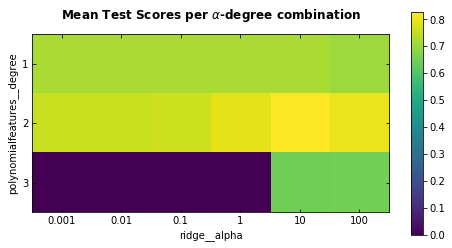

In [52]:
# plotting the results by mean_test_score
mean_t_scores = pipe_cv.cv_results_['mean_test_score'].reshape(3,-1)

plt.matshow(mean_t_scores, vmin=0, cmap='viridis', )
plt.title(r'Mean Test Scores per $\alpha$-degree combination', weight='bold')
plt.xlabel('ridge__alpha')
plt.ylabel('polynomialfeatures__degree')
plt.xticks(ticks=range(len(param_grid['ridge__alpha'])),
          labels=param_grid['ridge__alpha'])
plt.yticks(ticks=range(len(param_grid['polynomialfeatures__degree'])),
           labels=param_grid['polynomialfeatures__degree'])
plt.tick_params(top=True, bottom=True, right=True, direction='in',
                labelbottom=True, labeltop=False)
plt.colorbar()
plt.show()

It seems the best test score is achieved with degree=2 and $\alpha=10$, lets confirm it:

In [55]:
print('Best paramaters: {}'.format(pipe_cv.best_params_))
print('Best score: {:.3f}'.format(pipe_cv.score(X_test, y_test)))

Best paramaters: {'polynomialfeatures__degree': 2, 'ridge__alpha': 10}
Best score: 0.768


By comparison, let's run the grid-search without polynomial features:

In [57]:
param_grid = {'ridge__alpha': np.logspace(-3, 2, 6)}
pipe = make_pipeline(StandardScaler(), Ridge())
pipe_cv = GridSearchCV(pipe, param_grid, cv=5, iid=False,
                      return_train_score=False).fit(X_train, y_train)
print('Best score: {:.3f}'.format(pipe_cv.score(X_test, y_test)))

Best score: 0.627


* Grid-searching preprocessing paramaters and model paramaters simultaenously is very powerful
* Adding more paramaters to the grid exponentially increases the number of models needed to be built

## Grid-Searching Model Selection

* Could determine wether to use *StandardScaler()* or *MinMaxScaler*
* However, trying all possible solutions is not viable ML strategy

**Sample problem**:
* Compare *RandomForestClassifier* and *SVC*
* Wether to scale the data for *SVC* or not
* No preprocessing is needed for *RandomForestClassifier*

In [95]:
iris = datasets.load_iris()

pipe = Pipeline([('preprocessing', StandardScaler()),
                 ('classifier', SVC())])

# since we have classifiers with different 
# paramaters we make list of search grids
param_grid = [
    {'classifier':[SVC()], 'preprocessing':[StandardScaler(), None],
    'classifier__C': np.logspace(-3, 2, 6),
    'classifier__gamma': np.logspace(-3, 2, 6)},
    {'classifier': [RandomForestClassifier(100)],
    'classifier__max_features': [1,2,3],
    'preprocessing': [None]}]

X_train, X_test, y_train, y_test = train_test_split(
    iris.data, iris.target, random_state=0)

grid_cv = GridSearchCV(pipe, param_grid, cv=5, n_jobs=-1,
                      iid=False, return_train_score=False).fit(X_train, y_train)

print('Best paramters:\n{}\n'.format(grid_cv.best_params_))
print('Best cross-validation score: {:.3f}'.format(grid_cv.best_score_))
print('Test-set score: {:.3f}'.format(grid_cv.score(X_test, y_test)))

Best paramters:
{'classifier': SVC(C=100.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False), 'classifier__C': 100.0, 'classifier__gamma': 0.01, 'preprocessing': None}

Best cross-validation score: 0.973
Test-set score: 0.974


* GridSearchCV found that the best results are obtained if no preprocessing is used
* c = 100, gamma=0.01 gave the best results

Let's do the same on cancer dataset:

In [96]:
cancer = datasets.load_breast_cancer()

X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, random_state=0)

grid_cv = GridSearchCV(pipe, param_grid, cv=5, n_jobs=-1,
                      iid=False, return_train_score=False).fit(X_train, y_train)

print('Best paramters:\n{}\n'.format(grid_cv.best_params_))
print('Best cross-validation score: {:.3f}'.format(grid_cv.best_score_))
print('Test-set score: {:.3f}'.format(grid_cv.score(X_test, y_test)))

Best paramters:
{'classifier': SVC(C=10.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False), 'classifier__C': 10.0, 'classifier__gamma': 0.01, 'preprocessing': StandardScaler(copy=True, with_mean=True, with_std=True)}

Best cross-validation score: 0.986
Test-set score: 0.979


* GridSearchCV found that best results are obtained when data is scaled before
* C = 10, gamma = 0.01 gave the best results

## Summary

* Choosing the right combination of feature extraction, preprocessing, and models is somewhat of an art, and often requires some trial and error.
* Important to try if adding a step to the model is needed or not